In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from tqdm import tqdm
import pandas as pd
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import seaborn as sns

## Load data

In [3]:
train_data = pd.read_csv("../data/ds_test_train_1M.csv")
test_data = pd.read_csv("../data/ds_test_eval_100k.csv")

## Target variable

Text(0.5, 1.0, 'Train and test target distributions')

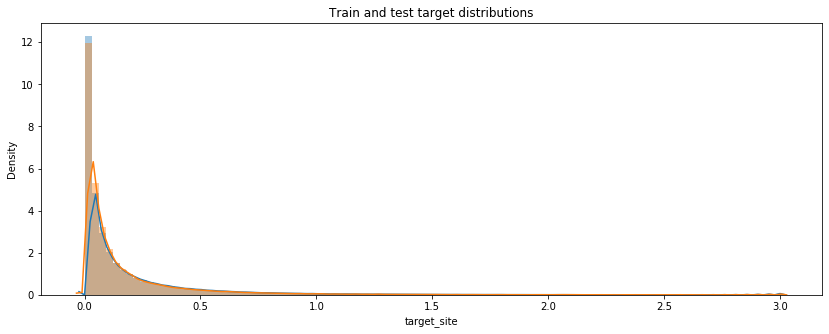

In [11]:
plt.figure(figsize = (14, 5))
sns.distplot(train_data["target_site"], bins=100)
sns.distplot(test_data["target_site"], bins=100)
plt.xlabel(col)
plt.ylabel("Density")
plt.title(f"Train and test target distributions")

### Target is skewed and contains outliers

## Missing values

In [4]:
train_missing = train_data.isnull().mean()
for ratio in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    cnt = (train_missing > ratio).sum()
    print(f"{cnt} train data features have more than {ratio*100}% missing values")

208 train data features have more than 0.0% missing values
127 train data features have more than 10.0% missing values
85 train data features have more than 20.0% missing values
52 train data features have more than 30.0% missing values
29 train data features have more than 40.0% missing values
26 train data features have more than 50.0% missing values
21 train data features have more than 60.0% missing values
0 train data features have more than 70.0% missing values
0 train data features have more than 80.0% missing values
0 train data features have more than 90.0% missing values


In [5]:
test_missing = test_data.isnull().mean()
for ratio in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    cnt = (test_missing > ratio).sum()
    print(f"{cnt} test data features have more than {ratio*100}% missing values")

205 test data features have more than 0.0% missing values
52 test data features have more than 10.0% missing values
52 test data features have more than 20.0% missing values
32 test data features have more than 30.0% missing values
26 test data features have more than 40.0% missing values
26 test data features have more than 50.0% missing values
15 test data features have more than 60.0% missing values
0 test data features have more than 70.0% missing values
0 test data features have more than 80.0% missing values
0 test data features have more than 90.0% missing values


### We can see there are lots of missing values in our data. 
### We can work on analysing and imputing the missing data.
### We can also use boosted tree models that handle missing data from the get go.
### We decide to use LightGBM for this exercice.

### TODO: try to analyse if missing values are missing at random or not

## Compare train and test feature distributions

100%|██████████| 209/209 [00:53<00:00,  3.94it/s]


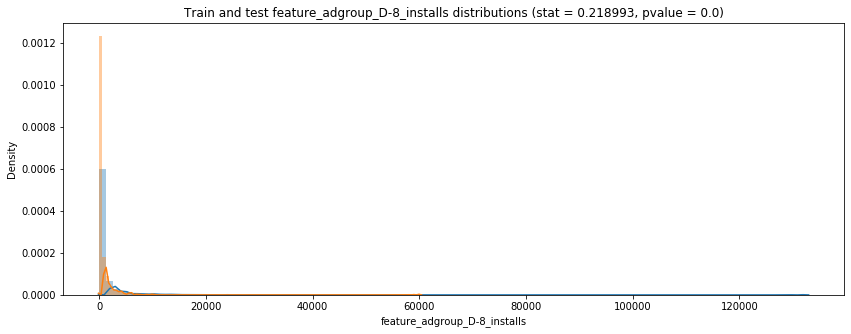

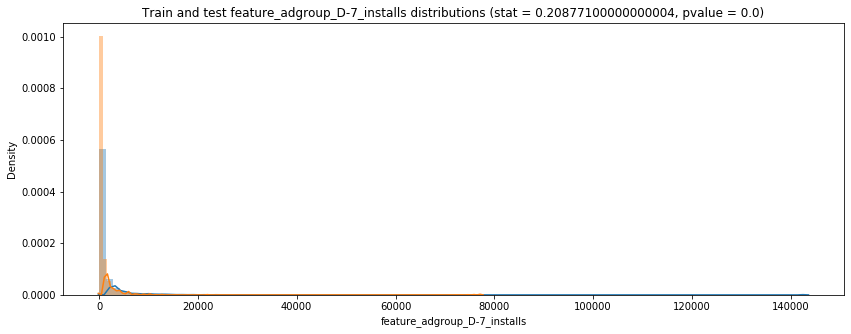

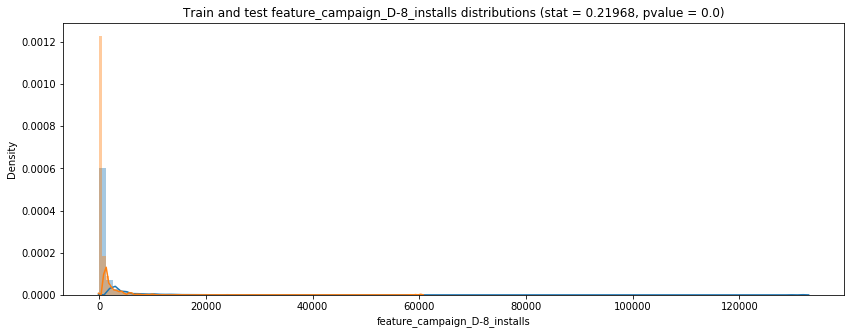

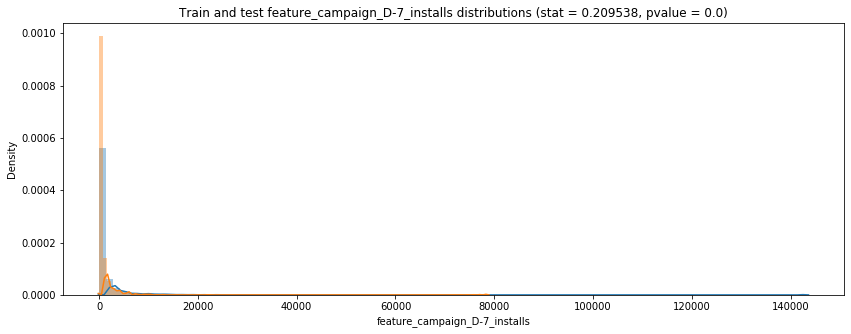

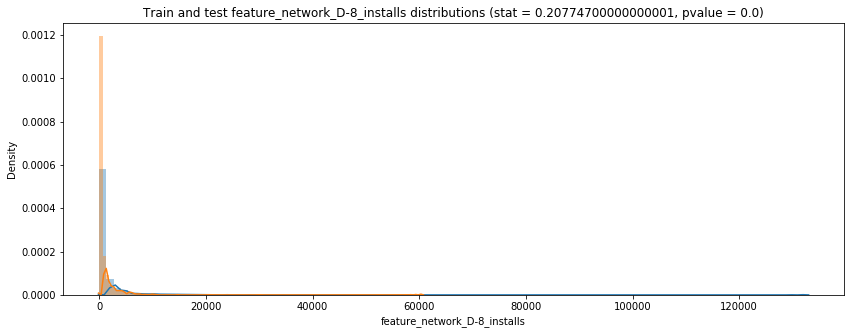

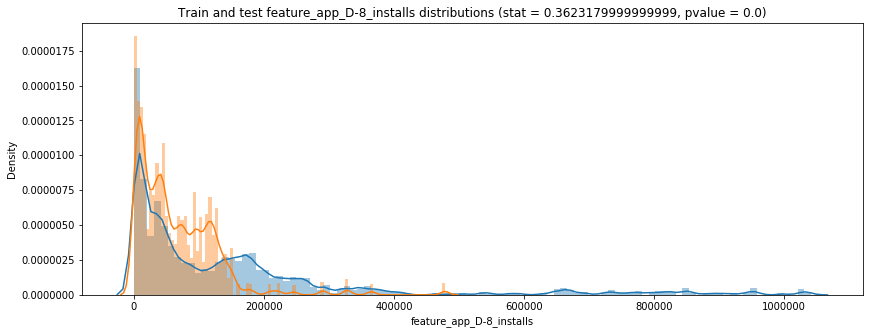

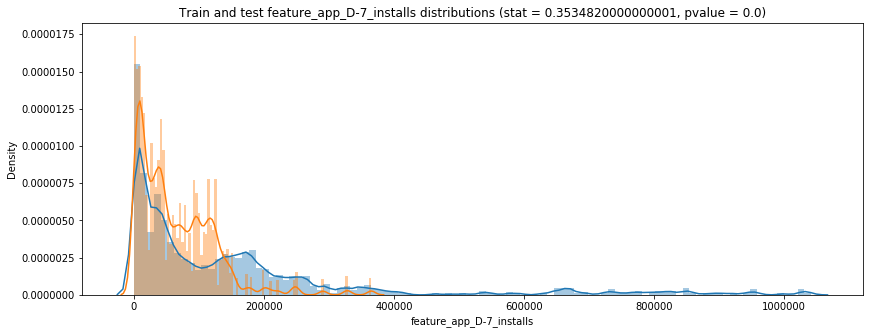

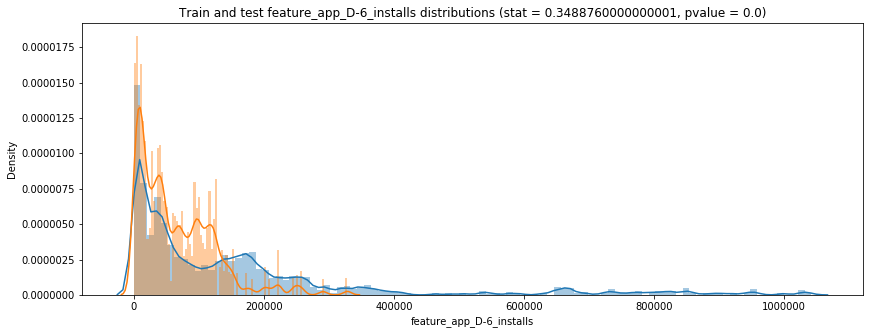

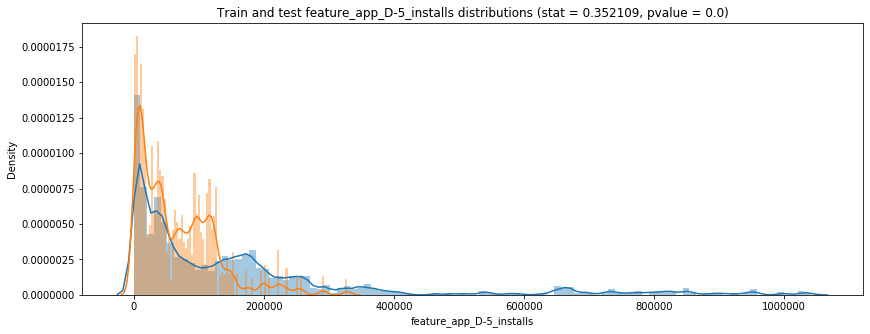

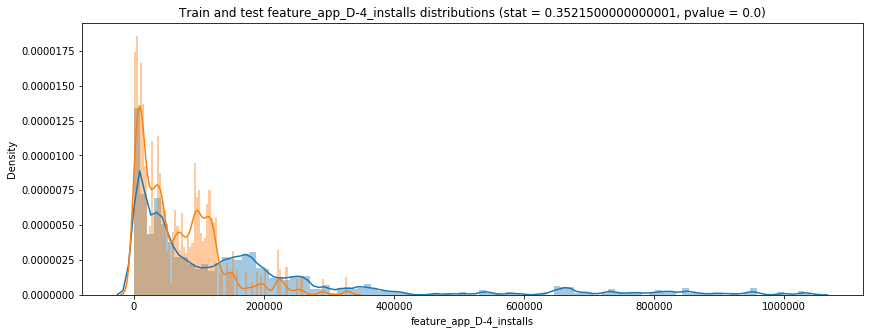

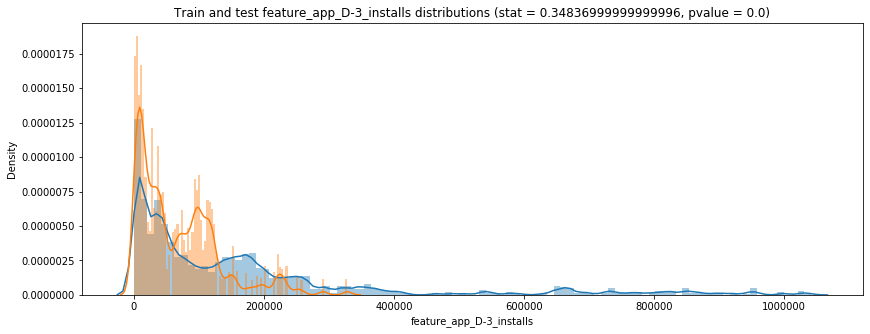

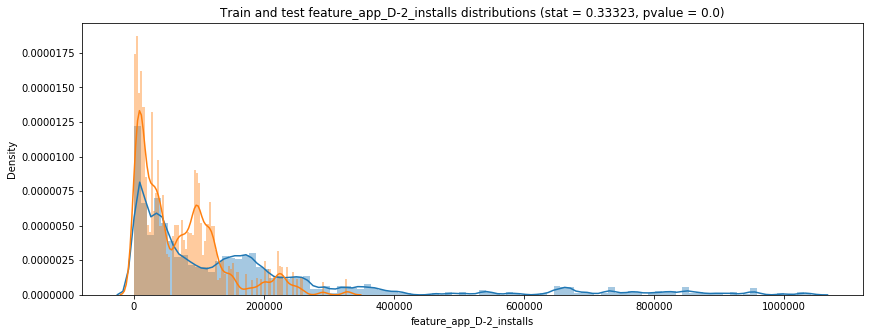

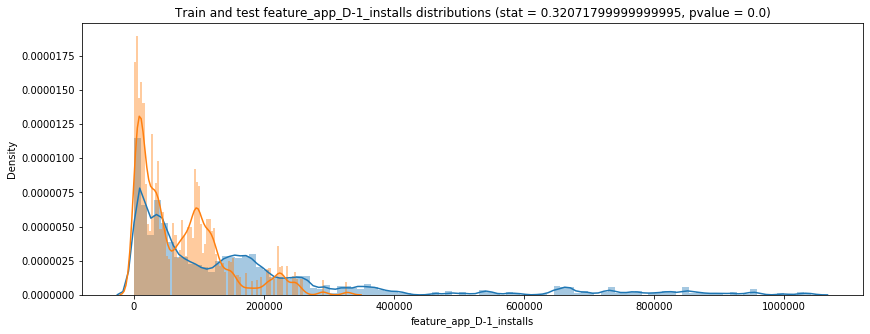

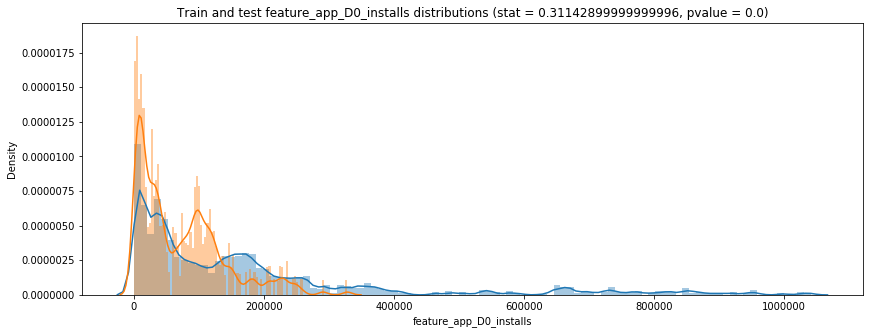

In [6]:
ks_test_threshold = 0.2
for col in tqdm(train_data.columns):
    statistic, pvalue = ks_2samp(
        train_data[col].values, 
        test_data[col].values
    )
    if statistic > ks_test_threshold and pvalue <= 0.05:
        plt.figure(figsize = (14, 5))
        sns.distplot(train_data[col], bins=100)
        sns.distplot(test_data[col], bins=100)
        plt.xlabel(col)
        plt.ylabel("Density")
        plt.title(f"Train and test {col} distributions (stat = {statistic}, pvalue = {pvalue})")

#### Some features have different distributions between train and test data.
#### In this exercice we don't do anything about it. But further analysis is warranted. Example we might want to discard these features.

## Do installs increase or decrease per day ?

### Let's look at a few examples

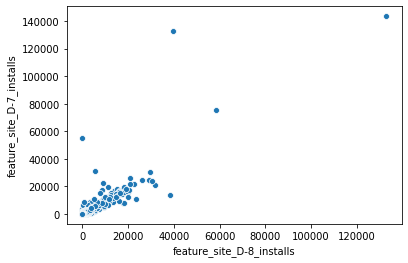

In [7]:
sns.scatterplot(train_data['feature_site_D-8_installs'], train_data['feature_site_D-7_installs'])

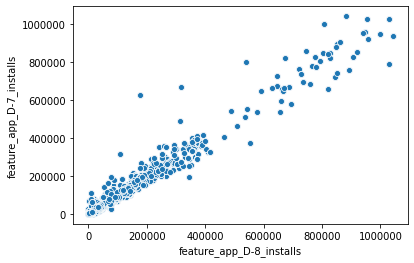

In [8]:
sns.scatterplot(train_data['feature_app_D-8_installs'], train_data['feature_app_D-7_installs'])

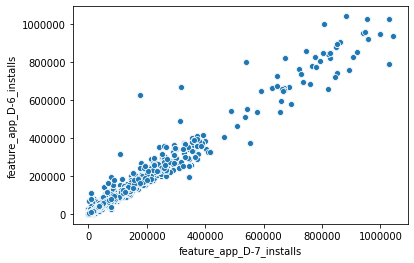

In [9]:
sns.scatterplot(train_data['feature_app_D-7_installs'], train_data['feature_app_D-6_installs'])

### Compute increase ratio

In [10]:
granularities = ["site", "app_site", "country_only", "adgroup", "campaign", "network", "country", "app"]
for granularity in granularities:
    for Dx in range(-7, 1):
        f1 = f"feature_{granularity}_D{Dx - 1}_installs"
        f2 = f"feature_{granularity}_D{Dx}_installs"
        diff = (train_data[f2] - train_data[f1]).dropna()
        increase_ratio = (diff > 0).mean()
        increase_avg_diff = (diff[diff > 0]).mean()
        decrease_avg_diff = (diff[diff <= 0]).mean()
        print(f"{f1} -> {f2} : increase ratio {increase_ratio}")
        print(f"{f1} -> {f2} : increase diff {increase_avg_diff}")
        print(f"{f1} -> {f2} : decrease diff {abs(decrease_avg_diff)}")
        print()

feature_site_D-8_installs -> feature_site_D-7_installs : increase ratio 0.3965962709768143
feature_site_D-8_installs -> feature_site_D-7_installs : increase diff 12.382499946600594
feature_site_D-8_installs -> feature_site_D-7_installs : decrease diff 7.535160746876316

feature_site_D-7_installs -> feature_site_D-6_installs : increase ratio 0.3946061065096468
feature_site_D-7_installs -> feature_site_D-6_installs : increase diff 10.725256694700995
feature_site_D-7_installs -> feature_site_D-6_installs : decrease diff 7.04162939146695

feature_site_D-6_installs -> feature_site_D-5_installs : increase ratio 0.3978103613762105
feature_site_D-6_installs -> feature_site_D-5_installs : increase diff 10.195551109280292
feature_site_D-6_installs -> feature_site_D-5_installs : decrease diff 7.06175327199689

feature_site_D-5_installs -> feature_site_D-4_installs : increase ratio 0.3969864675618396
feature_site_D-5_installs -> feature_site_D-4_installs : increase diff 9.510554612337295
feature_s

feature_adgroup_D-3_installs -> feature_adgroup_D-2_installs : increase ratio 0.46833101729838517
feature_adgroup_D-3_installs -> feature_adgroup_D-2_installs : increase diff 391.5344371572399
feature_adgroup_D-3_installs -> feature_adgroup_D-2_installs : decrease diff 266.11193152117096

feature_adgroup_D-2_installs -> feature_adgroup_D-1_installs : increase ratio 0.4694841037450824
feature_adgroup_D-2_installs -> feature_adgroup_D-1_installs : increase diff 404.148291613556
feature_adgroup_D-2_installs -> feature_adgroup_D-1_installs : decrease diff 271.40769026504006

feature_adgroup_D-1_installs -> feature_adgroup_D0_installs : increase ratio 0.47080346855449384
feature_adgroup_D-1_installs -> feature_adgroup_D0_installs : increase diff 434.75006964791777
feature_adgroup_D-1_installs -> feature_adgroup_D0_installs : decrease diff 277.6655784010615

feature_campaign_D-8_installs -> feature_campaign_D-7_installs : increase ratio 0.4694991376733907
feature_campaign_D-8_installs -> fea

feature_app_D-5_installs -> feature_app_D-4_installs : increase ratio 0.4959354895265626
feature_app_D-5_installs -> feature_app_D-4_installs : increase diff 22702.756747609965
feature_app_D-5_installs -> feature_app_D-4_installs : decrease diff 14958.837907653937

feature_app_D-4_installs -> feature_app_D-3_installs : increase ratio 0.48512695236913783
feature_app_D-4_installs -> feature_app_D-3_installs : increase diff 23397.061521548607
feature_app_D-4_installs -> feature_app_D-3_installs : decrease diff 15207.91017129254

feature_app_D-3_installs -> feature_app_D-2_installs : increase ratio 0.4804361999705555
feature_app_D-3_installs -> feature_app_D-2_installs : increase diff 23630.196177872724
feature_app_D-3_installs -> feature_app_D-2_installs : decrease diff 15571.003420540243

feature_app_D-2_installs -> feature_app_D-1_installs : increase ratio 0.47862947502557457
feature_app_D-2_installs -> feature_app_D-1_installs : increase diff 23329.372280696403
feature_app_D-2_installs

### We can notice that when number of installs increase the increase is on average higher than the decrease.
### Further analysis is warranted. 